In [1]:
import numpy as np

import jax.numpy as jnp
from jax import random, jit, grad, jacfwd
from jax.config import config
config.update('jax_enable_x64', True)

from jax.lax import fori_loop

from tqdm.notebook import trange

seed = 42
RNG = random.PRNGKey(seed)

from libs.manifold import SPD
from libs.minimizer import OPTIM

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 7]
# plt.rcParams['figure.dpi'] = 100

In [2]:
n_samples = 1000
p = 20
_tol = 1e-6

man = SPD(p)
optim = OPTIM(man, method='rsd', maxiter=200, mingradnorm=_tol, verbosity=1, logverbosity=True)

In [3]:
df = p + 4

mean = jnp.zeros((p))

RNG, key = random.split(RNG)
cov = man.rand(key)

RNG, key = random.split(RNG)
z = random.multivariate_normal(key, mean=jnp.zeros(p,), cov=cov, shape=(n_samples,))

RNG, key = random.split(RNG)
ws = jnp.sqrt(df / jnp.sum(random.normal(key, shape=(n_samples, df)) ** 2, axis=1))
data = mean + z * jnp.expand_dims(ws, 1)

true_cov = df / (df - 2) * cov

In [4]:
def loglik(X):
    def body(i, ll):
        si = jnp.outer(data[i], data[i]) / df
        return ll + jnp.log(1 + jnp.trace(jnp.linalg.solve(X, si)))
    
    llik = - (df + p) * 0.5 * fori_loop(0, n_samples, body, 0.)
    return llik - 0.5 * n_samples * jnp.linalg.slogdet(X)[1]

fun = jit(lambda X: - loglik(X))
gra = jit(jacfwd(fun))

true_fun = fun(cov)
t_g = gra(cov)
norm_t_g = man.norm(cov, t_g)
print(true_fun)
print(norm_t_g)

31563.861185741527
41145.60934743589


In [5]:
RNG, key = random.split(RNG)
init = man.rand(key)

results, logs = optim.solve(fun, gra, x=init)

Starting Riemannian Steepest Descent on the manifold of (20 x 20) positive definite matrices
Optimization completed in 81.30222773551941 s.
	Status: 1 -> status meaning: 0=converged, 1=stepsize too small, 2=max iters reached, 3=max time reached, 4=max cost evaluations, -1=undefined


In [8]:
print(results)
#print(cov)
print(fun(true_cov))
#print(true_cov)

Riemannian Steepest Descent on the manifold of (20 x 20) positive definite matrices.
---
Success: False with status 1 in 81.303 s.
[status meaning: 0=converged, 1=stepsize too small, 2=max iters reached, 3=max time reached, 4=max cost evaluations, -1=undefined]
 -Iteration 40 (cost evaluation: 92, gradient evaluation: 41, time/it: 2.0325672388076783)
 	 Function value 31455.421, gradient norm 1.0459951623490047e-05, stepsize 0.0,
 	 value of X:
	... Too big to show...
31581.93122672514


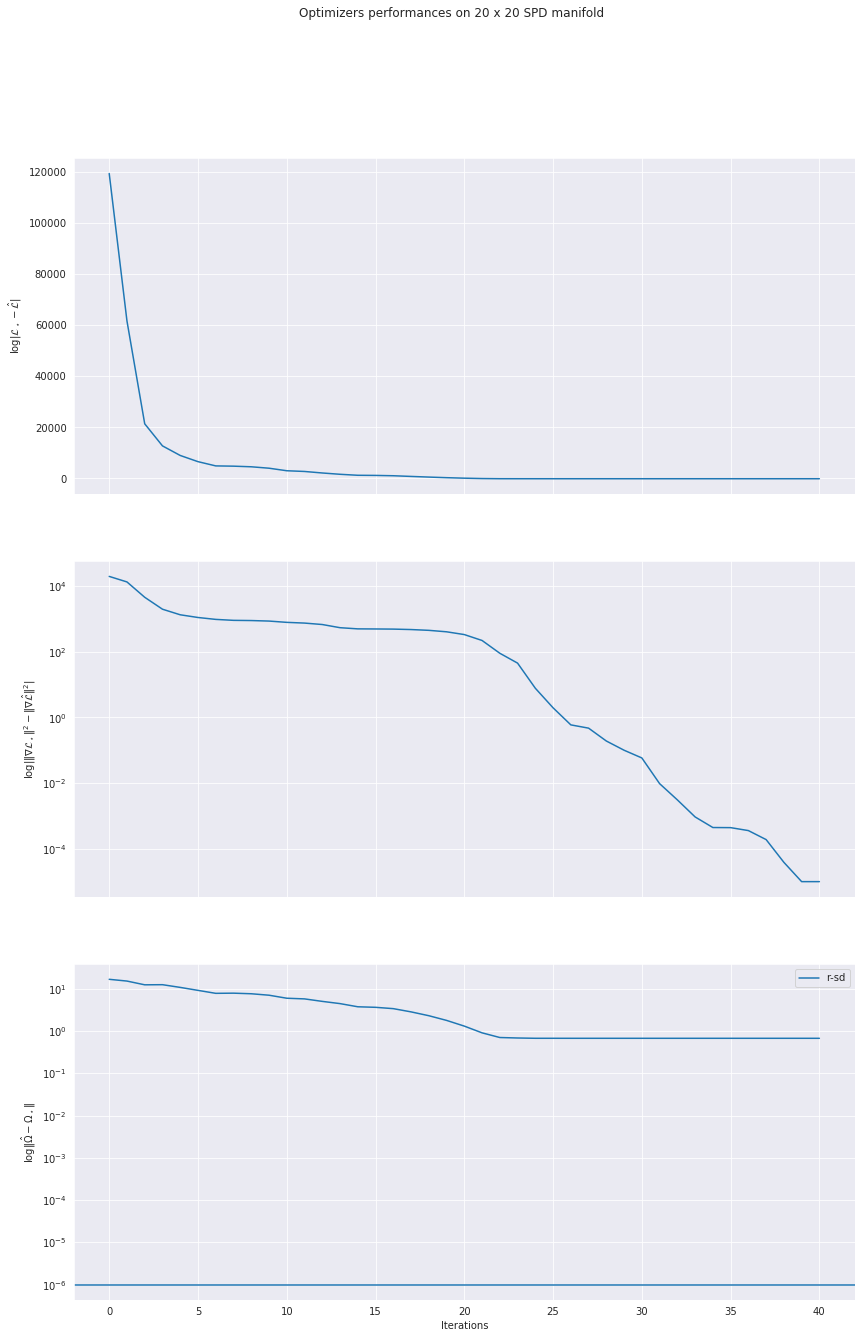

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14, 21))

ax1.plot(logs.it, logs.fun - true_fun, label='r-sd');
#ax1.axhline(y=_tol, xmin=0, xmax=results.nit);
#ax1.set_yscale('log');
ax1.set_ylabel(r'$\log\vert\mathcal{L}_\star - \hat{\mathcal{L}}\vert$');

ax2.plot(logs.it, logs.grnorm, label='r-sd');
#ax2.axhline(y=_tol, xmin=0, xmax=results.nit);
ax2.set_yscale('log');
ax2.set_ylabel(r'$\log\left\vert\Vert\nabla\mathcal{L}_\star\Vert^2 - \Vert\nabla\hat{\mathcal{L}}\Vert^2\right\vert$');

ax3.plot(logs.it, [man.dist(cov, logs.x[i]) for i in range(results.nit+1)], label='r-sd'); 
ax3.axhline(y=_tol, xmin=0, xmax=results.nit);
ax3.set_yscale('log');
ax3.set_ylabel(r'$\log\left\Vert\hat\Omega - \Omega_\star\right\Vert$');

f.suptitle('Optimizers performances on {0} x {0} SPD manifold'.format(p));
plt.xlabel('Iterations');
plt.legend();
plt.show()

In [14]:
seed = 42
RNG = random.PRNGKey(seed)

n_samples = 1000
ps = [2, 3, 4, 5, 10, 15, 20]
_tol = 1e-6

n_test = 10
n_reps = 5

tot_len = len(ps) * n_test * n_reps

In [11]:
mat_dim = np.zeros(shape=(tot_len), dtype=int)
times = np.zeros(shape=(tot_len))
iters = np.zeros(shape=(tot_len), dtype=int)
fun_diff = np.zeros(shape=(tot_len))
mat_diff = np.zeros(shape=(tot_len))
grnorm = np.zeros(shape=(tot_len))
i = 0

for p in ps:
    man = SPD(p)
    optim = OPTIM(man, method='rsd', maxiter=200, mingradnorm=_tol, verbosity=0)
    print(optim)
    
    for _ in trange(n_test):
        df = p + 2
        mean = jnp.zeros((p))

        RNG, key = random.split(RNG)
        cov = man.rand(key)

        RNG, key = random.split(RNG)
        z = random.multivariate_normal(key, mean=jnp.zeros(p,), cov=cov, shape=(n_samples,))

        RNG, key = random.split(RNG)
        ws = jnp.sqrt(df / jnp.sum(random.normal(key, shape=(n_samples, df)) ** 2, axis=1))
        
        data = mean + z * jnp.expand_dims(ws, 1)
        true_cov = df / (df - 2) * cov
        
        def loglik(X):
            def body(i, ll):
                si = jnp.outer(data[i], data[i]) / df
                return ll + jnp.log(1 + jnp.trace(jnp.linalg.solve(X, si)))
            
            llik = - (df + p) * 0.5 * fori_loop(0, n_samples, body, 0.)
            return llik - 0.5 * n_samples * jnp.linalg.slogdet(X)[1]

        fun = jit(lambda X: - loglik(X))
        gra = jit(jacfwd(fun))

        true_fun = fun(cov)
        true_gra = gra(cov)
        true_gra_norm = man.norm(cov, true_gra)
        
        for _ in range(n_reps):
            RNG, key = random.split(RNG)
            init = man.rand(key)
            
            result = optim.solve(fun, gra, x=init)
            mat_dim[i] = p
            times[i] = float(result.time)
            iters[i] = int(result.nit)
            fun_diff[i] = float(result.fun - true_fun)
            mat_diff[i] = float(man.dist(cov, result.x))
            grnorm[i] = float(result.grnorm)
            i += 1

df = pd.DataFrame({'p': mat_dim, 'time': times, 'iterations': iters, 'time / iterations': times / iters, 
        'fun diff': fun_diff, 'mat diff': mat_diff, 'gradient norm': grnorm})


df['convergence'] = df['fun diff'] < _tol

print('R-SD algorithm convergence ratio {:.2f} %'.format(len(df[df.convergence]) / tot_len * 100.))


Riemannian Steepest Descent on the manifold of (2 x 2) positive definite matrices



Riemannian Steepest Descent on the manifold of (3 x 3) positive definite matrices



Riemannian Steepest Descent on the manifold of (4 x 4) positive definite matrices



Riemannian Steepest Descent on the manifold of (5 x 5) positive definite matrices


AttributeError: 'DataFrame' object has no attribute 'algorithm'

R-SD algorithm convergence ratio 0.00 %


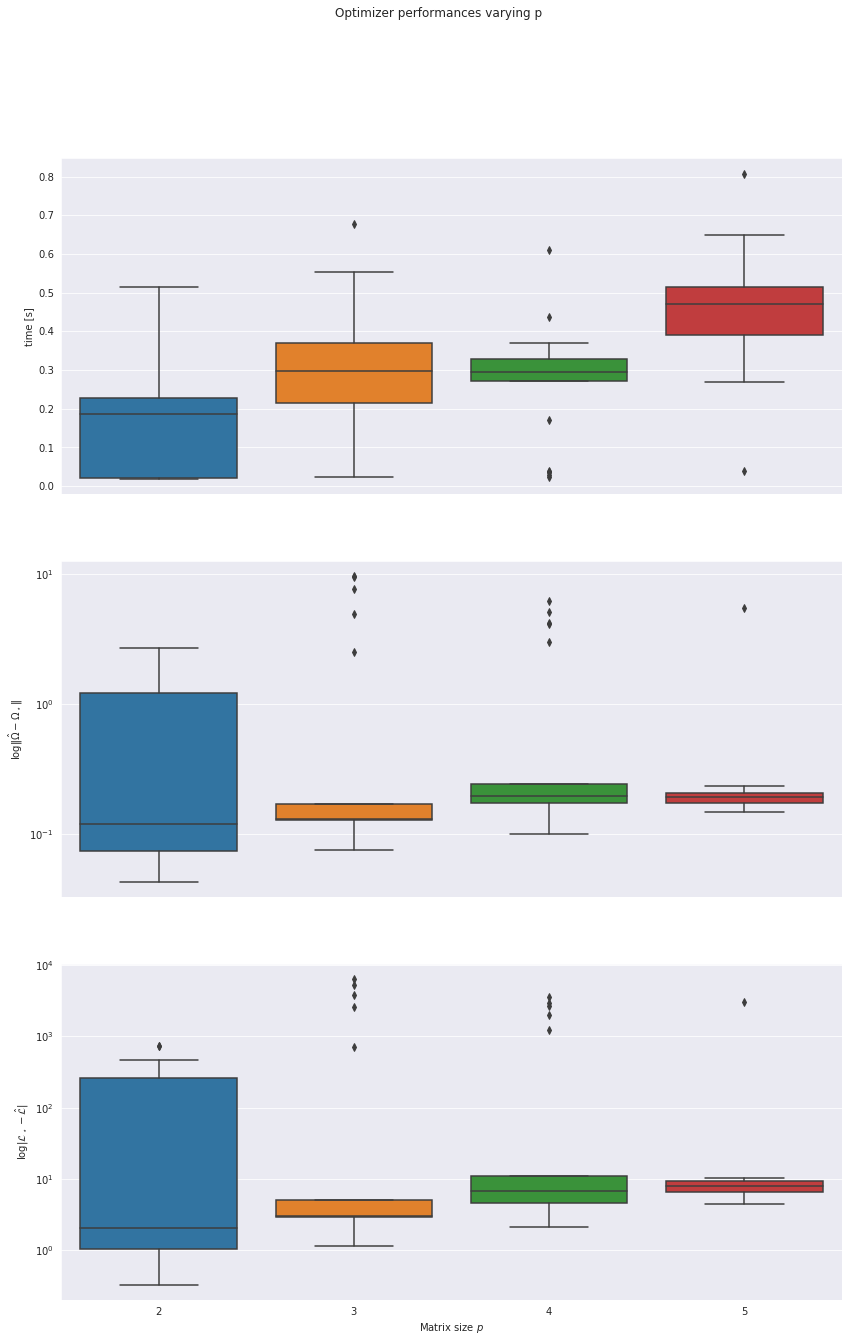

In [13]:
print('R-SD algorithm convergence ratio {:.2f} %'.format(len(df[df.convergence]) / tot_len * 100.))
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14, 21))

sns.boxplot(data=df, x='p', y='time', ax=ax1)
#ax1.set_yscale('log')

ax1.set_xlabel('');
ax1.set_ylabel('time [s]');

sns.boxplot(data=df, x='p', y='mat diff', ax=ax2)
ax2.set_yscale('log')
ax2.set_xlabel('');
ax2.set_ylabel(r'$\log\left\Vert\hat\Omega - \Omega_\star\right\Vert$');

sns.boxplot(data=df, x='p', y='fun diff', ax=ax3)
ax3.set_yscale('log')
ax3.set_ylabel(r'$\log\vert\mathcal{L}_\star - \hat{\mathcal{L}}\vert$');

f.suptitle('Optimizer performances varying p');
plt.xlabel(r'Matrix size $p$');
#plt.legend();
plt.show()